<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Netflix_2015_logo.svg" width="300">
</div>

# Netflix Global Top 10 Performance Predictor: Estimating Success from Early Data

In this notebook, we explore and analyse the Netflix Global Top 10 weekly dataset and build a multiple linear regression model to forecast a title's performance based on its first two weeks in the rankings.

This project is also available on [Kaggle](https://www.kaggle.com/code/davidpbriggs/netflix-global-top-10-performance-predictor).
## 1 Imports
We import relevant Python packages to clean, explore and analyse the data.

In [1]:
# Operational packages
import pandas as pd
import numpy as np
import math
import warnings

# Visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing, modeling, and evaluation packages
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error

We load the Netflix Global Top 10 weekly dataset into a pandas DataFrame and store it in the variable **top10_global_weekly**.

In [2]:
# Import TSV file into DataFrame
top10_global_weekly = pd.read_csv('https://www.kaggle.com/datasets/davidpbriggs/most-popular-netflix-shows?select=2025-03-07_global_weekly.tsv', sep='\t')

## 2 Data Exploration

### 2.1 Exploration & Cleaning

#### 2.1.1 Netflix Global Top 10 Weekly Dataset

We display the first 10 rows of the DataFrame.

In [3]:
# Display first 10 rows
top10_global_weekly.head()

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10,is_staggered_launch,runtime_override_flag,episode_launch_dtls
0,2025-03-02,Films (English),1,Venom: The Last Dance,NaN,23300000,1.8167,12800000.0,1,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
1,2025-03-02,Films (English),2,Despicable Me 4,NaN,13800000,1.5667,8800000.0,1,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
2,2025-03-02,Films (English),3,Despicable Me 3,NaN,10300000,1.5000,6900000.0,7,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
3,2025-03-02,Films (English),4,Minions,NaN,9000000,1.5167,5900000.0,12,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN
4,2025-03-02,Films (English),5,Uncharted,NaN,10100000,1.9333,5200000.0,5,False,"[{is_staggered_launch=0, is_live_title=0}]",NaN


In [4]:
# Get basic information
top10_global_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7680 entries, 0 to 7679
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        7680 non-null   object 
 1   category                    7680 non-null   object 
 2   weekly_rank                 7680 non-null   int64  
 3   show_title                  7680 non-null   object 
 4   season_title                3711 non-null   object 
 5   weekly_hours_viewed         7680 non-null   int64  
 6   runtime                     3600 non-null   float64
 7   weekly_views                3600 non-null   float64
 8   cumulative_weeks_in_top_10  7680 non-null   int64  
 9   is_staggered_launch         7680 non-null   bool   
 10  runtime_override_flag       3600 non-null   object 
 11  episode_launch_dtls         127 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 667.6+ KB


In [5]:
# Generate basic descriptive stats
top10_global_weekly.describe()

,weekly_rank,weekly_hours_viewed,runtime,weekly_views,cumulative_weeks_in_top_10
count,7680.000000,7.680000e+03,3600.000000,3.600000e+03,7680.000000
mean,5.500000,1.796999e+07,3.614009,4.702222e+06,3.121745
std,2.872468,2.588482e+07,3.022567,5.381986e+06,3.275340
min,1.000000,7.000000e+05,0.000000,6.000000e+05,1.000000
25%,3.000000,6.067500e+06,1.683300,1.800000e+06,1.000000
50%,5.500000,1.102500e+07,2.166700,3.100000e+06,2.000000
75%,8.000000,2.010750e+07,5.150000,5.300000e+06,4.000000
max,10.000000,5.717600e+08,23.366700,6.800000e+07,30.000000


We check the data types of the columns.

In [6]:
# Check datatypes
top10_global_weekly.dtypes

week                           object
category                       object
weekly_rank                     int64
show_title                     object
season_title                   object
weekly_hours_viewed             int64
runtime                       float64
weekly_views                  float64
cumulative_weeks_in_top_10      int64
is_staggered_launch              bool
runtime_override_flag          object
episode_launch_dtls            object
dtype: object

We convert **week** to a pandas datetime64 type for easier time-based analysis.

In [7]:
# Convert week column to datetime
top10_global_weekly['week']  = pd.to_datetime(top10_global_weekly['week'])

We convert **cumulative_weeks_in_top_10** and **weekly_hours_viewed** to float data types.

In [8]:
# Convert cumulative weeks and weekly hours viewed to float
top10_global_weekly['cumulative_weeks_in_top_10'] = top10_global_weekly['cumulative_weeks_in_top_10'].astype(float)
top10_global_weekly['weekly_hours_viewed'] = top10_global_weekly['weekly_hours_viewed'].astype(float)

We check for missing values.

In [9]:
# Check for missing values
top10_global_weekly.isnull().sum()

week                             0
category                         0
weekly_rank                      0
show_title                       0
season_title                  3969
weekly_hours_viewed              0
runtime                       4080
weekly_views                  4080
cumulative_weeks_in_top_10       0
is_staggered_launch              0
runtime_override_flag         4080
episode_launch_dtls           7553
dtype: int64

We replace **season_title** with **show_title** where **season_title** has a null value.

In [10]:
# Replace null values in season_title with corresponding values from show_title
top10_global_weekly['season_title'] = top10_global_weekly['season_title'].fillna(top10_global_weekly['show_title'])

We drop the columns **runtime**, **weekly_views**, **runtime_override_flag** and **episode_launch_dtls** due to a high proportion of null values. This is likely a result of changes in Netflix's data collection methods.

In [11]:
# Drop columns with large number of null values
subset_top10_global_weekly = top10_global_weekly.drop(columns=['runtime', 'weekly_views', 'runtime_override_flag', 'episode_launch_dtls'])
subset_top10_global_weekly.isnull().sum()

week                          0
category                      0
weekly_rank                   0
show_title                    0
season_title                  0
weekly_hours_viewed           0
cumulative_weeks_in_top_10    0
is_staggered_launch           0
dtype: int64

We check for duplicate entries and remove them if necessary.

In [12]:
# Check for duplicates
subset_top10_global_weekly.duplicated().sum()

0

In [13]:
# Drop duplicates
subset_top10_global_weekly.drop_duplicates().reset_index(drop=True)

,week,category,weekly_rank,show_title,season_title,weekly_hours_viewed,cumulative_weeks_in_top_10,is_staggered_launch
0,2025-03-02,Films (English),1,Venom: The Last Dance,Venom: The Last Dance,23300000.0,1.0,False
1,2025-03-02,Films (English),2,Despicable Me 4,Despicable Me 4,13800000.0,1.0,False
2,2025-03-02,Films (English),3,Despicable Me 3,Despicable Me 3,10300000.0,7.0,False
3,2025-03-02,Films (English),4,Minions,Minions,9000000.0,12.0,False
4,2025-03-02,Films (English),5,Uncharted,Uncharted,10100000.0,5.0,False
...,...,...,...,...,...,...,...,...
7675,2021-07-04,TV (Non-English),6,Elite,Elite: Season 1,10530000.0,1.0,False
7676,2021-07-04,TV (Non-English),7,Elite,Elite: Season 3,10200000.0,1.0,False
7677,2021-07-04,TV (Non-English),8,Elite,Elite: Season 2,10140000.0,1.0,False
7678,2021-07-04,TV (Non-English),9,Katla,Katla: Season 1,9190000.0,1.0,False


#### 2.1.2 DataFrame for Modeling

We create a new DataFrame for modeling and store it in the variable **summary_top10_global_weekly**. We group the weekly data by **season_title**, aggregating key metrics such as **total_hours_viewed_in_top_10** and **total_weeks_in_top_10**. Additionally we capture **weekly_hours_viewed** and **weekly_rank** for the title's first two weeks in Netflix's Global Top 10. For titles that remain in the rankings for only one week, we set **week2_hours_viewed** as 0 and **week2_rank** as 11.

In [14]:
# Sort by date
subset_top10_global_weekly = subset_top10_global_weekly.sort_values(by='week', ascending=True)

# Group by 'season_title' and aggregate the data
summary_top10_global_weekly = subset_top10_global_weekly.groupby('season_title').agg(
    show_title=('show_title', 'first'),
    category=('category', 'first'),
    total_hours_viewed_in_top_10=('weekly_hours_viewed', 'sum'),
    total_weeks_in_top_10=('cumulative_weeks_in_top_10', 'max'),
    is_staggered_launch=('is_staggered_launch', 'first'),
    week1_hours_viewed=('weekly_hours_viewed', 'first'),
    week1_rank=('weekly_rank', 'first'),
    week2_hours_viewed=('weekly_hours_viewed', lambda x: x.iloc[1] if len(x) > 1 else 0),
    week2_rank=('weekly_rank', lambda x: x.iloc[1] if len(x) > 1 else 11)
).reset_index()

# Sort by total hours viewed
summary_top10_global_weekly = summary_top10_global_weekly.sort_values(by='total_hours_viewed_in_top_10', ascending=False).reset_index(drop=True)
summary_top10_global_weekly.head()

,season_title,show_title,category,total_hours_viewed_in_top_10,total_weeks_in_top_10,is_staggered_launch,week1_hours_viewed,week1_rank,week2_hours_viewed,week2_rank
0,Squid Game: Season 1,Squid Game,TV (Non-English),2.664700e+09,29.0,False,63190000.0,1,448730000.0,1
1,Stranger Things 4,Stranger Things,TV (English),1.887310e+09,19.0,False,286790000.0,1,335010000.0,1
2,Wednesday: Season 1,Wednesday,TV (English),1.806850e+09,20.0,False,341230000.0,1,411290000.0,1
3,Squid Game: Season 2,Squid Game,TV (Non-English),1.353300e+09,10.0,False,487600000.0,1,417100000.0,1
4,Bridgerton: Season 2,Bridgerton,TV (English),1.027000e+09,22.0,False,193020000.0,1,251740000.0,1


We plot a line graph showing the weekly viewing of all 7,680 Netflix Global Top 10 titles, labeling the three most popular.

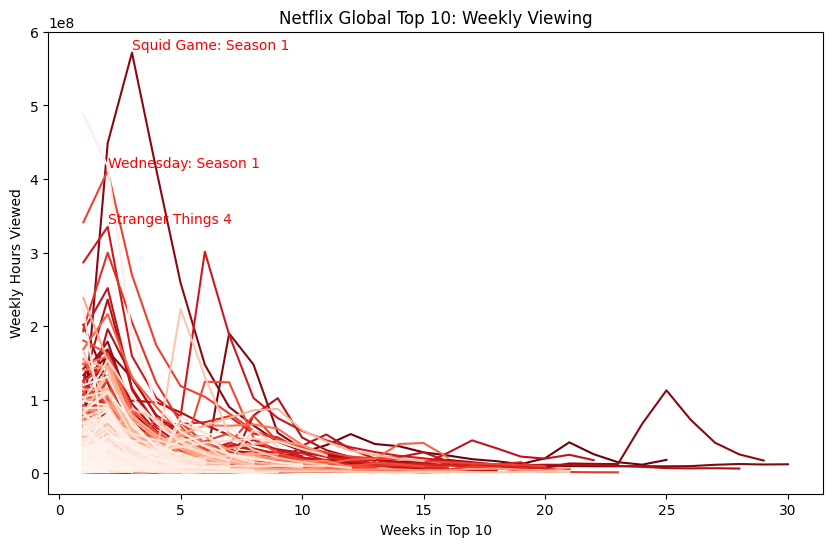

In [15]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Get the most viewed titles
most_viewed_titles = summary_top10_global_weekly['season_title'].head(3)

# Set up the plot size
plt.figure(figsize=(10, 6))

# Create the line plot
sns.lineplot(data=subset_top10_global_weekly, 
             x='cumulative_weeks_in_top_10', 
             y='weekly_hours_viewed', 
             hue='season_title',
             legend=False,
             palette="Reds_r")

# Annotate the the most viewed titles
for title in most_viewed_titles:
    # Filter the data for the current title
    title_data = subset_top10_global_weekly[subset_top10_global_weekly['season_title'] == title]
    
    # Get the row with the maximum 'weekly_hours_viewed'
    peak_row = title_data.loc[title_data['weekly_hours_viewed'].idxmax()]
    
    # Annotate the plot with the season title at the peak of weekly_hours_viewed
    plt.text(peak_row['cumulative_weeks_in_top_10'],
             peak_row['weekly_hours_viewed'],
             title,
             fontsize=10,
             ha='left',
             va='bottom',
             color='red')

# Add labels and title
plt.title('Netflix Global Top 10: Weekly Viewing')
plt.xlabel('Weeks in Top 10')
plt.ylabel('Weekly Hours Viewed')

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_weekly.png', format='png')

# Display the plot
plt.show()

We plot a bar chart showing the total hours viewed of the most popular Netflix Global Top 10 titles.

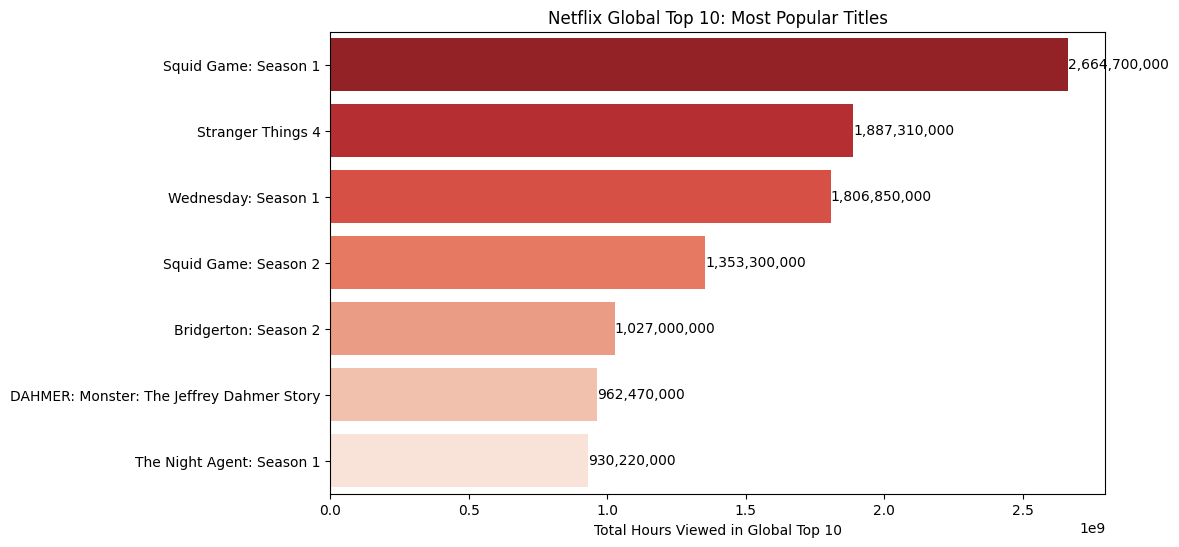

In [16]:
# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="total_hours_viewed_in_top_10", 
    y="season_title", 
    data=summary_top10_global_weekly.head(7), 
    palette="Reds_r"
)

# Add labels on the bars
for index, value in enumerate(summary_top10_global_weekly.head(7)['total_hours_viewed_in_top_10']):
    ax.text(value, index, f"{value:,.0f}", va='center')

# Set labels and title
plt.xlabel("Total Hours Viewed in Global Top 10")
plt.ylabel("")
plt.title("Netflix Global Top 10: Most Popular Titles")

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_total_hours_viewed.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

We plot a bar chart showing the titles that spent the most weeks in the Netflix Global Top 10.

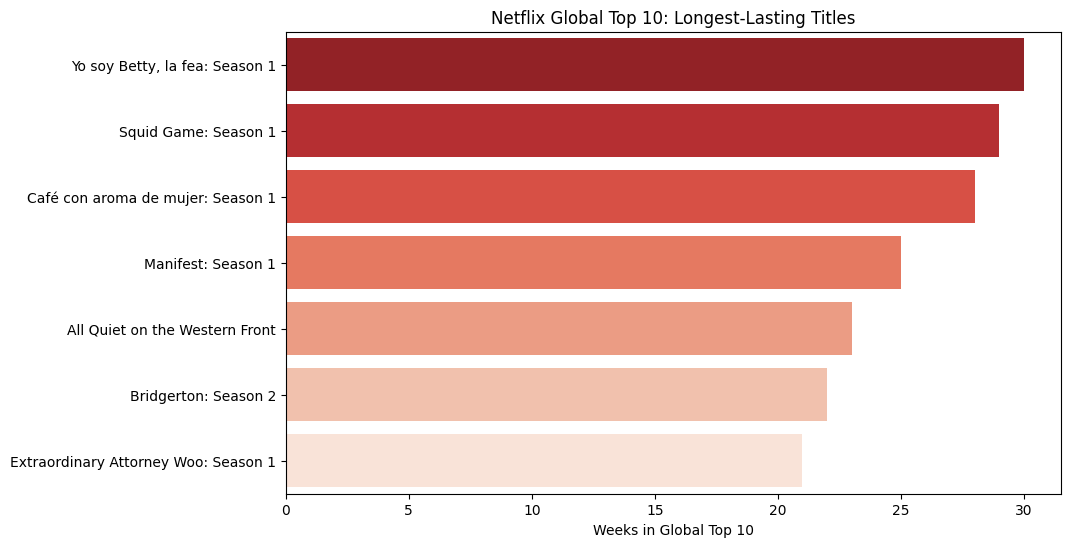

In [17]:
# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="total_weeks_in_top_10", 
    y="season_title", 
    data=summary_top10_global_weekly.sort_values(by='total_weeks_in_top_10', ascending=False).head(7), 
    palette="Reds_r"
)

# Set labels and title
plt.xlabel("Weeks in Global Top 10")
plt.ylabel("")
plt.title("Netflix Global Top 10: Longest-Lasting Titles")

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_total_weeks.png', format='png', bbox_inches='tight')

# Display the plot
plt.show()

We check summary information for the new DataFrame.

In [18]:
# Check summary info
summary_top10_global_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2759 entries, 0 to 2758
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   season_title                  2759 non-null   object 
 1   show_title                    2759 non-null   object 
 2   category                      2759 non-null   object 
 3   total_hours_viewed_in_top_10  2759 non-null   float64
 4   total_weeks_in_top_10         2759 non-null   float64
 5   is_staggered_launch           2759 non-null   bool   
 6   week1_hours_viewed            2759 non-null   float64
 7   week1_rank                    2759 non-null   int64  
 8   week2_hours_viewed            2759 non-null   float64
 9   week2_rank                    2759 non-null   int64  
dtypes: bool(1), float64(4), int64(2), object(3)
memory usage: 196.8+ KB


We analyse descriptive statistics.

In [19]:
# Get descriptive stats
summary_top10_global_weekly.describe()

,total_hours_viewed_in_top_10,total_weeks_in_top_10,week1_hours_viewed,week1_rank,week2_hours_viewed,week2_rank
count,2.759000e+03,2759.00000,2.759000e+03,2759.000000,2.759000e+03,2759.000000
mean,5.002157e+07,2.77963,1.626772e+07,5.545487,1.501621e+07,6.686843
std,1.134326e+08,2.62000,2.357384e+07,2.914172,2.814769e+07,3.831827
min,8.000000e+05,1.00000,8.000000e+05,1.000000,0.000000e+00,1.000000
25%,7.900000e+06,1.00000,5.600000e+06,3.000000,0.000000e+00,3.000000
50%,1.806000e+07,2.00000,9.880000e+06,6.000000,6.900000e+06,7.000000
75%,4.769500e+07,3.00000,1.805500e+07,8.000000,1.734000e+07,11.000000
max,2.664700e+09,30.00000,4.876000e+08,10.000000,4.487300e+08,11.000000


We plot a histogram showing the distribution of **total_hours_viewed_in_top_10**.

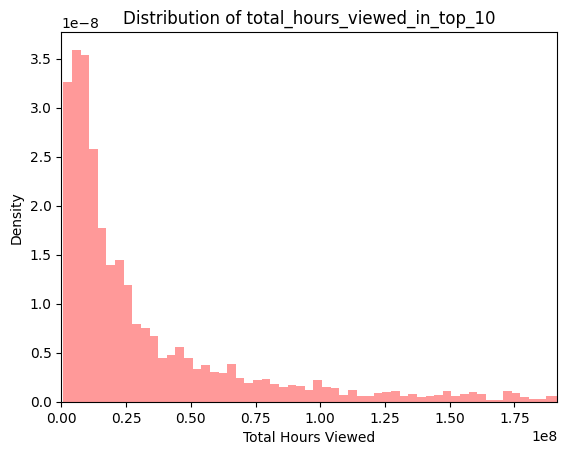

In [20]:
# Calculate the 95th percentile for total hours viewed
percentile95 = summary_top10_global_weekly['total_hours_viewed_in_top_10'].quantile(0.95)

# Visualise the data
plt.hist(summary_top10_global_weekly['total_hours_viewed_in_top_10'], bins=800, density=True, alpha=0.4, color='red')
plt.xlim(0, percentile95)
plt.title("Distribution of total_hours_viewed_in_top_10")
plt.xlabel('Total Hours Viewed')
plt.ylabel('Density')
plt.show()

The distribution is right-skewed, with the average Netflix Global Top 10 title recording 50 million hours, and the maximum at 2.6 billion hours ('Squid Game: Season 1').

We create a boxplot to visually inspect any potential outliers that could influence our model.

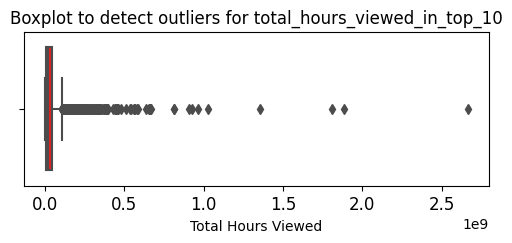

In [21]:
# Create a boxplot to visualise distribution of `total_hours_viewed_in_top_10`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for total_hours_viewed_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_hours_viewed_in_top_10',
            data = summary_top10_global_weekly,
            color="red")
plt.xlabel("Total Hours Viewed")
plt.show()


We apply a logarithmic transformation to normalise the distribution and reduce skewness.

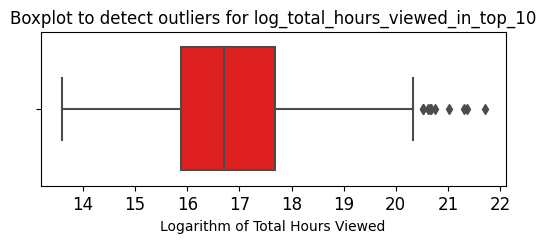

In [22]:
# Apply log safely (use log1p for non-negative values)
summary_top10_global_weekly.loc[:, 'log_total_hours_viewed_in_top_10'] = np.log1p(summary_top10_global_weekly['total_hours_viewed_in_top_10'])

# Create new boxplot to visualise distribution of transformed variable `log_total_hours_viewed_in_top_10`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for log_total_hours_viewed_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_total_hours_viewed_in_top_10',
            data = summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Total Hours Viewed")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

In [23]:
# Check for and handle outliers for total_hours_viewed_in_top_10
# Calculate 25th percentile of video_like_count
percentile25 = summary_top10_global_weekly['log_total_hours_viewed_in_top_10'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = summary_top10_global_weekly['log_total_hours_viewed_in_top_10'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered_summary_top10_global_weekly = summary_top10_global_weekly[
    (summary_top10_global_weekly['log_total_hours_viewed_in_top_10'] >= lower_limit) &
    (summary_top10_global_weekly['log_total_hours_viewed_in_top_10'] <= upper_limit)
]


We visualise the distribution of the transformed data.

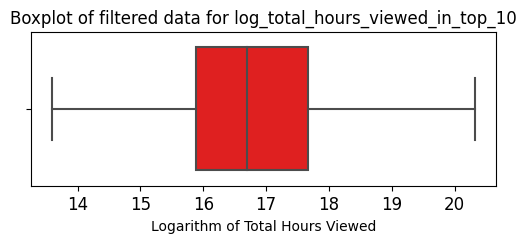

In [24]:
# Create boxplot of transformed data
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for log_total_hours_viewed_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_total_hours_viewed_in_top_10',
            data = filtered_summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Total Hours Viewed")
plt.show()


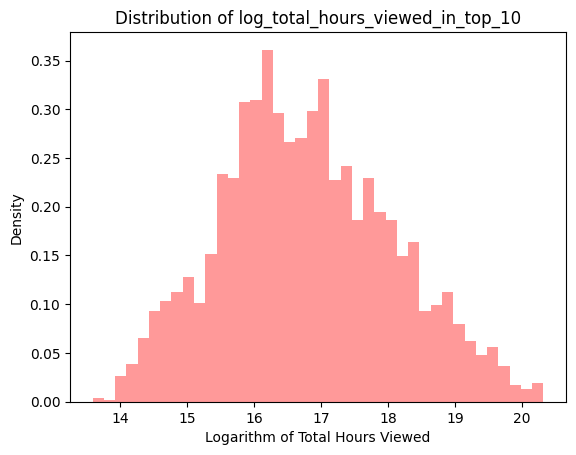

In [25]:
# Create histogram of transformed data
plt.hist(filtered_summary_top10_global_weekly['log_total_hours_viewed_in_top_10'],
         bins=40,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of log_total_hours_viewed_in_top_10")
plt.xlabel('Logarithm of Total Hours Viewed')
plt.ylabel('Density')
plt.show()

We plot a histogram showing the distribution of **total_weeks_in_top_10**.

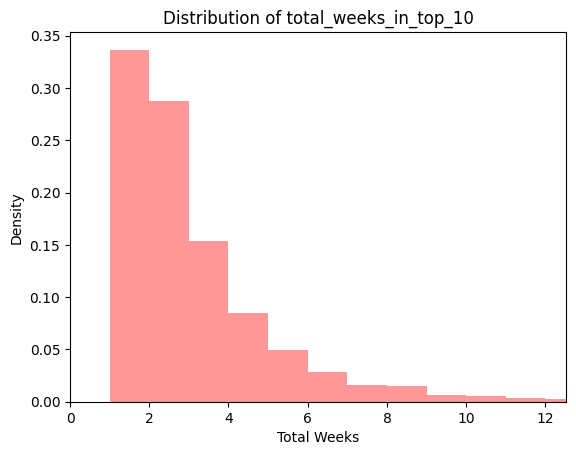

In [26]:
# Calculate the 99th percentile for weeks in Top 10
percentile99 = filtered_summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.99)

# Visualise the data
bin_width = 1
bins = np.arange(filtered_summary_top10_global_weekly['total_weeks_in_top_10'].min(), 
                 filtered_summary_top10_global_weekly['total_weeks_in_top_10'].max() + bin_width, 
                 bin_width)
plt.hist(filtered_summary_top10_global_weekly['total_weeks_in_top_10'],
         bins=bins,
         density=True,
         alpha=0.4,
         color='red')
plt.xlim(0, percentile99)
plt.title("Distribution of total_weeks_in_top_10")
plt.xlabel('Total Weeks')
plt.ylabel('Density')
plt.show()

The distribution is right-skewed, with the average Netflix Global Top 10 title remaining in the rankings for 2.8 weeks, and the maximum at 30 weeks ('Yo soy Betty, la fea: Season 1').

We create a boxplot to visually inspect any potential outliers that could influence our model.

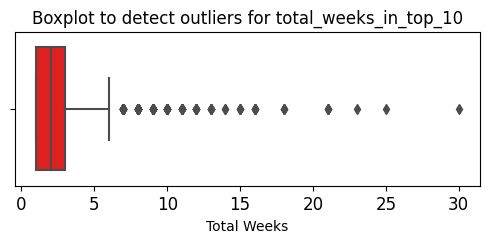

In [27]:
# Create a boxplot to visualise distribution of `total_weeks_in_top_10`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for total_weeks_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_weeks_in_top_10',
            data = filtered_summary_top10_global_weekly,
            color='red')
plt.xlabel("Total Weeks")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

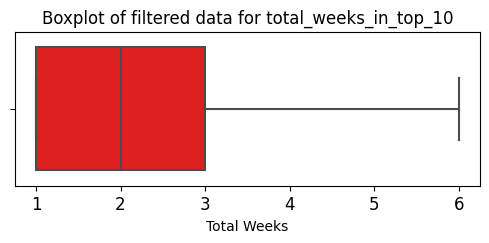

In [28]:
# Check for and handle outliers for total_hours_viewed_in_top_10
# Calculate 25th percentile of video_like_count
percentile25 = filtered_summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = filtered_summary_top10_global_weekly['total_weeks_in_top_10'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered2_summary_top10_global_weekly = filtered_summary_top10_global_weekly[
    (filtered_summary_top10_global_weekly['total_weeks_in_top_10'] >= lower_limit) &
    (filtered_summary_top10_global_weekly['total_weeks_in_top_10'] <= upper_limit)
]

# Check new distribution
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for total_weeks_in_top_10', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'total_weeks_in_top_10',
            data = filtered2_summary_top10_global_weekly,
            color='red')
plt.xlabel("Total Weeks")
plt.show()

We create a boxplot of **week1_hours_viewed** to identify potential outliers that could affect the effectiveness of our model.

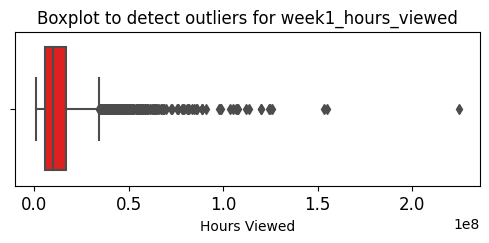

In [29]:
# Create a boxplot to visualise distribution of `week1_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for week1_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week1_hours_viewed',
            data = filtered2_summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

We apply a logarithmic transformation to normalise the distribution.

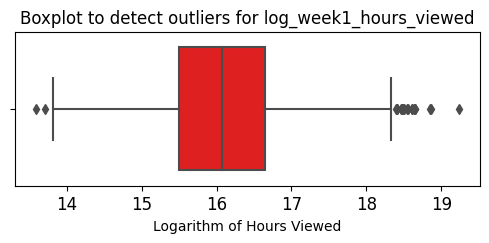

In [30]:
# Ensure a separate copy of the DataFrame is made before applying transformations
filtered2_summary_top10_global_weekly = filtered2_summary_top10_global_weekly.copy()

# Apply log safely (use log1p for non-negative values)
filtered2_summary_top10_global_weekly.loc[:, 'log_week1_hours_viewed'] = np.log1p(filtered2_summary_top10_global_weekly['week1_hours_viewed'])

# Create new boxplot to visualise distribution of transformed variable `log_week1_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for log_week1_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_week1_hours_viewed',
            data = filtered2_summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Hours Viewed")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

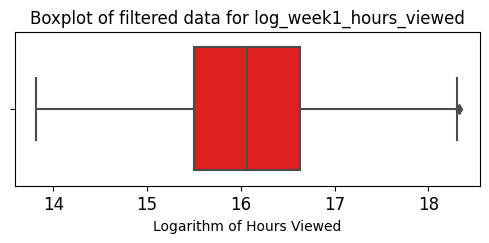

In [31]:
# Check for and handle outliers for log_week1_hours_viewed
# Calculate 25th percentile of video_like_count
percentile25 = filtered2_summary_top10_global_weekly['log_week1_hours_viewed'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = filtered2_summary_top10_global_weekly['log_week1_hours_viewed'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered3_summary_top10_global_weekly = filtered2_summary_top10_global_weekly[
    (filtered2_summary_top10_global_weekly['log_week1_hours_viewed'] >= lower_limit) &
    (filtered2_summary_top10_global_weekly['log_week1_hours_viewed'] <= upper_limit)
]

# Check new distribution
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for log_week1_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_week1_hours_viewed',
            data = filtered3_summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Hours Viewed")
plt.show()

We visualise the distribution of the transformed data.

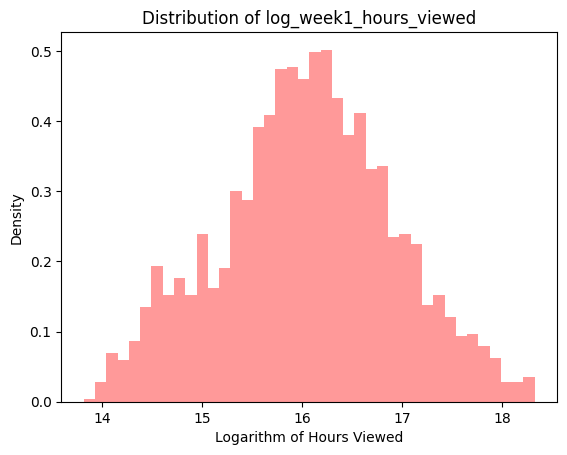

In [32]:
# Visualise the transformed data
plt.hist(filtered3_summary_top10_global_weekly['log_week1_hours_viewed'],
         bins=40,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of log_week1_hours_viewed")
plt.xlabel('Logarithm of Hours Viewed')
plt.ylabel('Density')
plt.show()

We create a boxplot and histogram of **week2_hours_viewed** to identify potential outliers that could affect the effectiveness of our model.

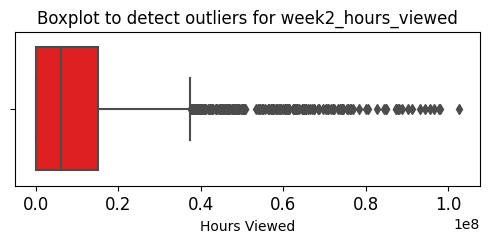

In [33]:
# Create a boxplot to visualise distribution of `week2_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for week2_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'week2_hours_viewed',
            data = filtered3_summary_top10_global_weekly,
            color='red')
plt.xlabel("Hours Viewed")
plt.show()

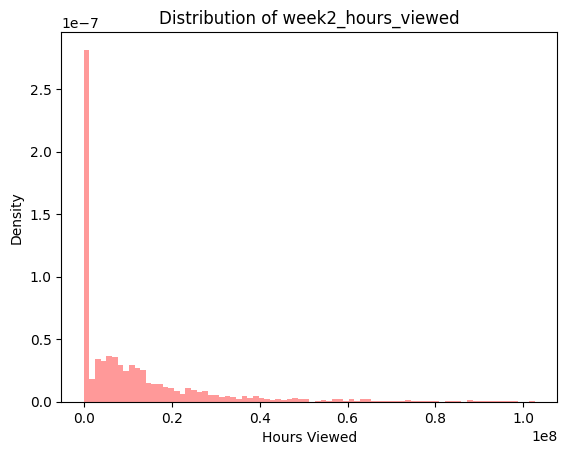

In [34]:
# Create a histogram
plt.hist(filtered3_summary_top10_global_weekly['week2_hours_viewed'],
         bins=80,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of week2_hours_viewed")
plt.xlabel('Hours Viewed')
plt.ylabel('Density')
plt.show()

We remove rows where **week2_hours_viewed** is 0.

In [35]:
# Create mask
mask = (filtered3_summary_top10_global_weekly['week2_hours_viewed'] != 0)

# Apply mask to filter out rows
filtered4_summary_top10_global_weekly = filtered3_summary_top10_global_weekly[mask]

We apply a logarithmic transformation to normalise the distribution.

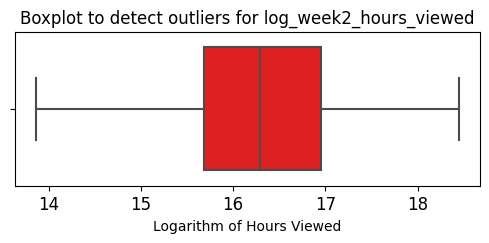

In [36]:
# Ensure a separate copy of the DataFrame is made before applying transformations
filtered4_summary_top10_global_weekly = filtered4_summary_top10_global_weekly.copy()

# Apply log safely (use log1p for non-negative values)
filtered4_summary_top10_global_weekly.loc[:, 'log_week2_hours_viewed'] = np.log1p(filtered4_summary_top10_global_weekly['week2_hours_viewed'])

# Create new boxplot to visualise distribution of transformed variable `log_week2_hours_viewed`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for log_week2_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_week2_hours_viewed',
            data = filtered4_summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Hours Viewed")
plt.show()

We remove rows where values fall outside the interquartile range (IQR).

In [37]:
# Check for and handle outliers for log_week2_hours_viewed
# Calculate 25th percentile of video_like_count
percentile25 = filtered4_summary_top10_global_weekly['log_week2_hours_viewed'].quantile(0.25)

# Calculate 75th percentile of annual strikes
percentile75 = filtered4_summary_top10_global_weekly['log_week2_hours_viewed'].quantile(0.75)

# Calculate interquartile range
iqr = percentile75 - percentile25

# Calculate upper and lower thresholds for outliers
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

# Filter out rows with outliers
filtered5_summary_top10_global_weekly = filtered4_summary_top10_global_weekly[
    (filtered4_summary_top10_global_weekly['log_week2_hours_viewed'] >= lower_limit) &
    (filtered4_summary_top10_global_weekly['log_week2_hours_viewed'] <= upper_limit)
]

We visualise the distribution of the transformed data.

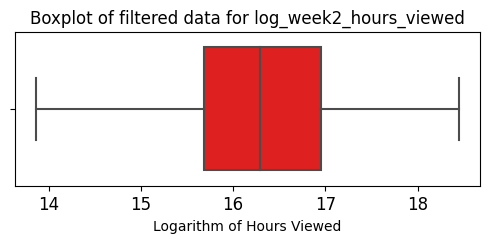

In [38]:
# Create boxplot of transformed data
plt.figure(figsize=(6,2))
plt.title('Boxplot of filtered data for log_week2_hours_viewed', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x = 'log_week2_hours_viewed',
            data = filtered5_summary_top10_global_weekly,
            color='red')
plt.xlabel("Logarithm of Hours Viewed")
plt.show()

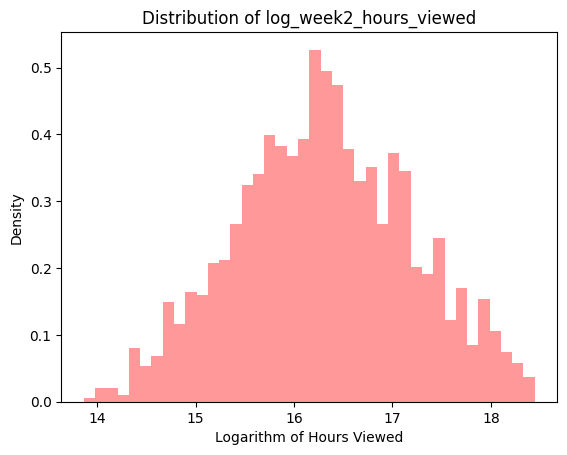

In [39]:
# Create histogram of transformed data
plt.hist(filtered5_summary_top10_global_weekly['log_week2_hours_viewed'],
         bins=40,
         density=True,
         alpha=0.4,
         color='red')
plt.title("Distribution of log_week2_hours_viewed")
plt.xlabel('Logarithm of Hours Viewed')
plt.ylabel('Density')
plt.show()

### 2.2 Examine correlations
#### 2.2.1 Continuous variables
We examine correlations among continuous variables to assess their suitability for modeling.

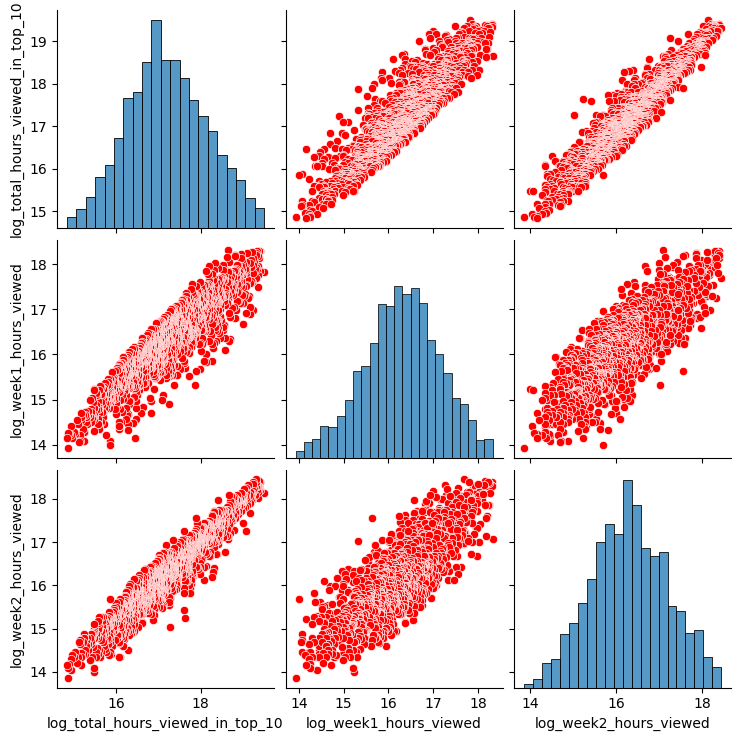

In [40]:
# Assign DataFrame to new variable and reset index
data = filtered5_summary_top10_global_weekly.reset_index(drop=True)

# Create pairwise scatterplots of continuous variables
sns.pairplot(data[[
             'log_total_hours_viewed_in_top_10',
             'log_week1_hours_viewed',
             'log_week2_hours_viewed']],
             plot_kws={'color': 'red'})

# Show the plot
plt.show()

The scatterplots indicate potentially linear relationships between **log_total_hours_viewed_in_top_10** and **log_week1_hours_viewed** and **log_week2_hours_viewed** respectively. This indicates that linearity may be a reasonable assumption for modeling.

#### 2.2.2 Categoric variables
We examine correlations with categoric variables to assess their suitability for modeling.

<Axes: xlabel='category', ylabel='log_total_hours_viewed_in_top_10'>

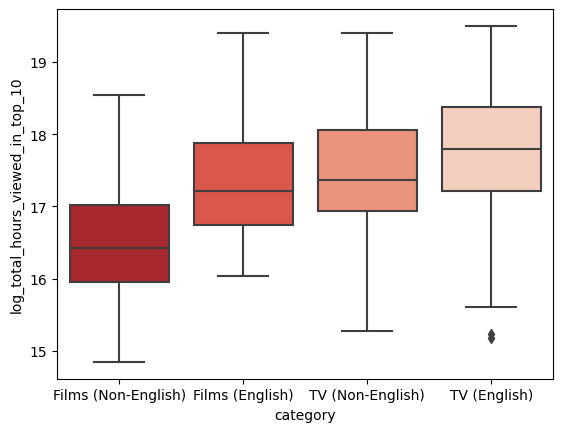

In [41]:
# Define the desired order of categories
category_order = ["Films (Non-English)", "Films (English)", "TV (Non-English)", "TV (English)"]

# Create boxplot to show distribution of 'log_total_hours_viewed_in_top_10' by 'category'
sns.boxplot(x = "category",
            y = "log_total_hours_viewed_in_top_10",
            data = data,
            order=category_order,
            palette='Reds_r')

The boxplot indicates an association between **category** and **total_hours_viewed_in_top_10**, suggesting this could be relevant for modeling.

#### 2.2.3 Boolean variables
We examine correlations with boolean variables to assess suitability for modeling.

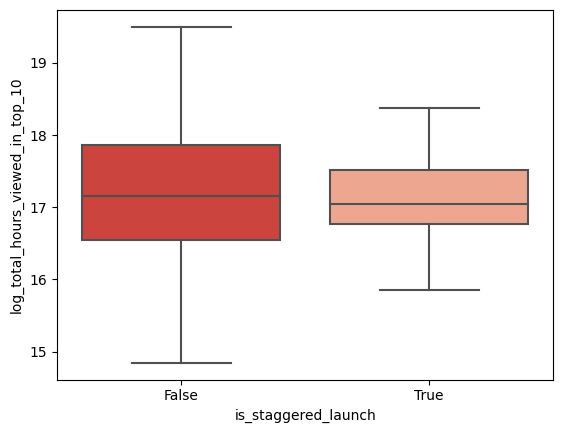

is_staggered_launch
False    1635
True        6
Name: count, dtype: int64

In [42]:
# Create boxplot to show distribution of 'log_total_hours_viewed_in_top_10' by boolean variable 'is_staggered_launch'
sns.boxplot(x="is_staggered_launch",
            y="log_total_hours_viewed_in_top_10",
            data=data,
            palette='Reds_r')
plt.show()

data['is_staggered_launch'].value_counts()

We observe that **is_staggered_launch** has an imbalanced distribution and weak correlation with **log_total_hours_viewed_in_top_10**.

## 3 Model Construction
### 3.1 Select variables

We will build a multiple linear regression model to forecast the performance of a Netflix title based on its first two weeks in the Global Top 10 rankings.

We select **log_total_hours_viewed_in_top_10** as the dependent variable ($y$) that our model will predict. Independent variables ($x_i$) will be selected from data available during a title's first two weeks in the Global Top 10.


| Dependent variable ($y$)                      | Potential independent variables ($x_i$)|
|---------------------------------------------|----------------------------------------|
| **log_total_hours_viewed_in_top_10** (continuous, log transformed) |  **log_week1_hours_viewed** (continuous, log transformed)  |
|                                             |  **log_week2_hours_viewed** (continuous, log transformed)  |
|                                             |  **week1_rank** (ordinal)                                  |
|                                             |  **week2_rank** (ordinal)                                  |
|                                             |  **category** (categorical)                                |
|                                             |  **is_staggered_launch** (boolean)                         |

#### 3.1.1 Model assumptions

To inform our selection of independent variables ($x_i$), we review the assumptions underlying multiple linear regression modeling.

* **Linearity** - The pairwise scatterplots (see section 2.2.1) suggest a linear relationship between the dependent variable and the continuous independent variables, which supports the assumption of linearity.

* **Independent observations** - While there may be some correlation in the performance of different seasons of the same Netflix show, we conclude that, overall, each observation in the dataset can be treated as independent.

* **Normality** - This assumption will be checked after the model is constructed.

* **Homoscedasticity** - This assumption will be checked after the model is constructed.

* **No multicollinearity** - We check for multicollinearity by calculating the variance inflation factors (VIFs) to assess whether any of the potential predictor variables are highly correlated:

In [43]:
# Create numeric subset of predictor variables
x_subset = data[[
    'log_week1_hours_viewed',
    'log_week2_hours_viewed',
    'week1_rank',
    'week2_rank']]

# Calculate variance inflation factors
vif = [variance_inflation_factor(x_subset.values, i) for i in range(x_subset.shape[1])]

# Pair column names with their VIF values
vif_df = pd.DataFrame({'Variable': x_subset.columns, 'VIF': vif})

# Display VIF values
vif_df

,Variable,VIF
0,log_week1_hours_viewed,2140.716363
1,log_week2_hours_viewed,2135.170120
2,week1_rank,10.192869
3,week2_rank,10.397505


We observe extremely high VIFs for **log_week1_hours_viewed** and **log_week2_hours_viewed**, indicating a strong correlation between these predictor variables.

To further assess multicollinearity, we visualise the correlation matrix using a heatmap:

<Axes: >

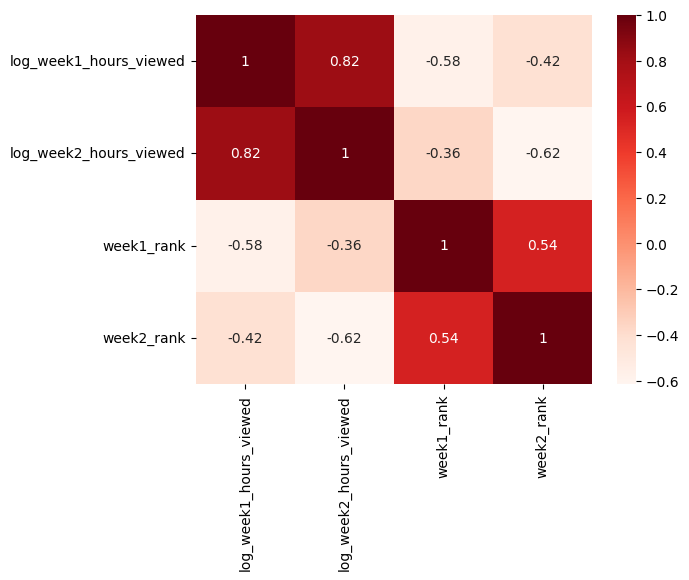

In [44]:
# Create a heatmap visualisation of correlation matrix
sns.heatmap(x_subset.corr(numeric_only=True),
            annot=True,
            cmap="Reds")

We note strong correlation between **log_week1_hours_viewed** and **log_week2_hours_viewed** (correlation coefficient: 0.82) and moderate correlation between other variables. Since multiple linear regression assumes *no multicollinearity* among independent variables, we decide to exclude **log_week2_hours_viewed** from the model.


#### 3.1.2 One-way ANOVA

To determine whether to include the **category** variable in our model, we will perform a one-way Analysis of Variance (ANOVA) test. For this, we create a simple linear regression model with **log_total_hours_viewed_in_top_10** as the dependent variable and **category** as the independent variable.

In [45]:
# Create a copy of the subset of the dataset
data_subset = data[['log_total_hours_viewed_in_top_10','category']].copy()

# Convert 'category' to a categorical type
data_subset['category'] = data_subset['category'].astype('category')

# Construct simple linear regression and fit the model
model = ols(formula = 'log_total_hours_viewed_in_top_10 ~ C(category)', data = data_subset).fit()

# Get summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     log_total_hours_viewed_in_top_10   R-squared:                       0.283
Model:                                          OLS   Adj. R-squared:                  0.282
Method:                               Least Squares   F-statistic:                     215.2
Date:                              Sat, 15 Mar 2025   Prob (F-statistic):          1.15e-117
Time:                                      10:18:20   Log-Likelihood:                -1940.2
No. Observations:                              1641   AIC:                             3888.
Df Residuals:                                  1637   BIC:                             3910.
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             17.3404      0.038    460.809      0.000      17.267      17.414
C(category)[T.Films (Non-English)]    -0.8493      0.052    -16.420      0.000      -0.951      -0.748
C(category)[T.TV (English)]            0.4374      0.056      7.811      0.000       0.328       0.547
C(category)[T.TV (Non-English)]        0.1255      0.057      2.203      0.028       0.014       0.237
==============================================================================
Omnibus:                       16.967   Durbin-Watson:                   0.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.363
Skew:                           0.100   Prob(JB):                      0.00207
Kurtosis:                       2.625   Cond. No.                         4.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The **category** beta coefficients all have a p-value of less than 0.05, indicating statistical significance. We now proceed with the one-way ANOVA test:

* $H_0$ Null Hypothesis: There is no difference in a title's performance based on **category**
* $H_1$ Alternative Hypothesis: There is a difference in a title's performance based on **category**

In [46]:
# Run one-way ANOVA
warnings.filterwarnings("ignore", category=RuntimeWarning)
sm.stats.anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
C(category),403.156685,3.0,215.197076,1.150818e-117
Residual,1022.268372,1637.0,NaN,NaN


The F-test statistic is 215.19 and the p-value is $1.15 \times 10^{-117}$ (ie. extremely small). Because the p-value is less than 0.05, we reject the null hypothesis that there is no difference in a title's performance based on **category**.

For completeness, we conduct an ANOVA post hoc test using Tukey's Honestly Significantly Different (HSD) test:

In [47]:
# Run Tukey's HSD post hoc test for one-way ANOVA
tukey_oneway = pairwise_tukeyhsd(endog = data_subset['log_total_hours_viewed_in_top_10'],
                                 groups = data_subset['category'],
                                 alpha = 0.05)

# Get results (pairwise comparisons)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Films (English),Films (Non-English),-0.8493,0.0,-0.9823,-0.7162,True
Films (English),TV (English),0.4374,0.0,0.2934,0.5814,True
Films (English),TV (Non-English),0.1255,0.1229,-0.021,0.2721,False
Films (Non-English),TV (English),1.2867,0.0,1.1463,1.427,True
Films (Non-English),TV (Non-English),0.9748,0.0,0.8318,1.1177,True
TV (English),TV (Non-English),-0.3119,0.0,-0.4652,-0.1586,True


Each row represents a pairwise comparison between the performance of titles in different categories. Based on the values in the 'reject' column, we can reject each null hypothesis with one exception ('Films (English)' vs 'TV (Non-English)'). This confirms a correlation between **category** and a title's performance. Therefore, we choose to include this variable in our model.

We exclude **is_staggered_launch** due to its highly unbalanced distribution and low correlation with a title's performance.

In summary, the variables selected are as follows:

| Dependent variable ($y$)                      | Independent variables ($x_i$)|
|---------------------------------------------|----------------------------------------|
| **log_total_hours_viewed_in_top_10** (continuous, log transformed) |  **log_week1_hours_viewed** (continuous, log transformed)  |
|                                             |  **week1_rank** (ordinal)                                  |
|                                             |  **week2_rank** (ordinal)                                  |
|                                             |  **category** (categorical)                                |

### 3.2 Train-Test Split

We split the data into training and test sets.

In [48]:
# Select dependent variable
y = data['log_total_hours_viewed_in_top_10']

# Select independent variables
x = data[[
    'log_week1_hours_viewed',
    'week1_rank',
    'week2_rank',
    'category']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42)

# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1230, 4), (411, 4), (1230,), (411,))

### 3.3 Model Building
We construct the model and fit it to the training set.

In [49]:
# Write out OLS formula as a string (C denotes categorical var)
ols_formula = "log_total_hours_viewed_in_top_10 ~ log_week1_hours_viewed + week1_rank + week2_rank + C(category)"

# Create OLS dataframe
ols_data = pd.concat([X_train, y_train], axis = 1)

# Create OLS object and fit the model
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

We complete our check of the model assumptions:

* **Normality** - We verify that the errors are normally distributed.

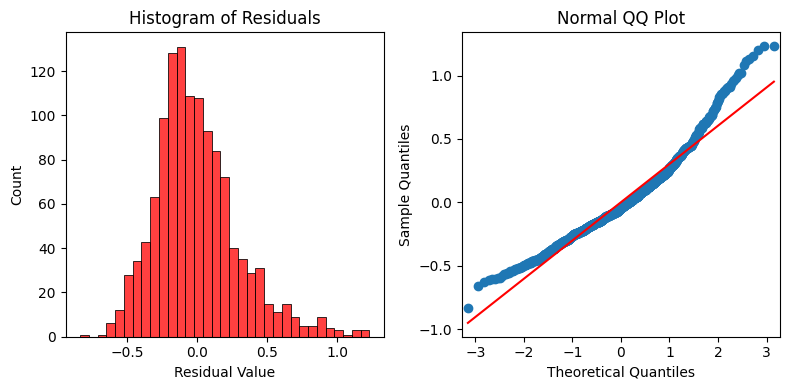

In [50]:
# Calculate the residuals
residuals = model.resid

# Create a 1x2 plot figure
fig, axes = plt.subplots(1, 2, figsize = (8,4))

# Create a histogram with the residuals
sns.histplot(residuals, ax=axes[0], color='red')
axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")

# Create a Q-Q plot of the residuals
sm.qqplot(residuals, line='s',ax = axes[1])
axes[1].set_title("Normal QQ Plot")

# Add space between plots for a cleaner appearance
plt.tight_layout()

# Show the plot
plt.show()


The histogram and Q-Q plot suggest that the residuals of our model do not follow a perfect normal distribution, indicating potential skewness. However, the violation of this assumption is not severe. While this may affect the validity of statistical tests, such as hypothesis tests for the coefficients, which rely on the normality of residuals, the impact is likely minimal.

* **Homoscedasticity** -  We check that the variation of the errors is constant or similar across the model.

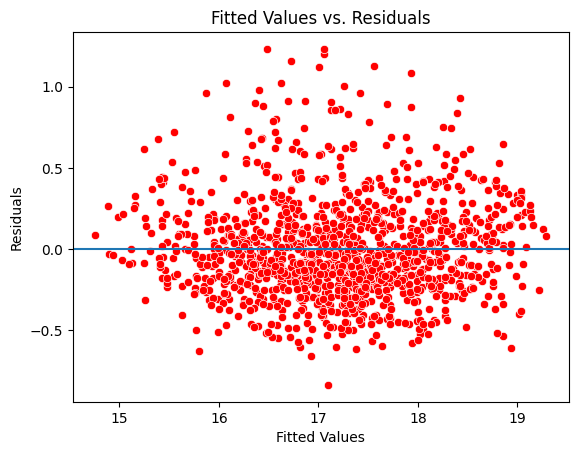

In [51]:
# Create a scatterplot with the fitted values from the model and the residuals
fitted_values = model.predict()
fig = sns.scatterplot(x=fitted_values, y=residuals, color='red')
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
fig.set_title("Fitted Values vs. Residuals")
fig.axhline(0) # Add reference line at residuals = 0
plt.show()

The scatterplot of fitted values versus residuals shows some clustering, but overall, it suggests that the homoscedasticity assumption is not severely violated. We conclude that the model assumptions are satisfied.

We review the model results.

In [52]:
# Get model results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     log_total_hours_viewed_in_top_10   R-squared:                       0.898
Model:                                          OLS   Adj. R-squared:                  0.897
Method:                               Least Squares   F-statistic:                     1789.
Date:                              Sat, 15 Mar 2025   Prob (F-statistic):               0.00
Time:                                      10:18:23   Log-Likelihood:                -272.43
No. Observations:                              1230   AIC:                             558.9
Df Residuals:                                  1223   BIC:                             594.7
Df Model:                                         6                                         
Covariance Type:                          nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              3.5500      0.312     11.361      0.000       2.937       4.163
C(category)[T.Films (Non-English)]    -0.1583      0.027     -5.772      0.000      -0.212      -0.104
C(category)[T.TV (English)]            0.1575      0.026      6.000      0.000       0.106       0.209
C(category)[T.TV (Non-English)]        0.1795      0.025      7.073      0.000       0.130       0.229
log_week1_hours_viewed                 0.8548      0.018     47.955      0.000       0.820       0.890
week1_rank                             0.0510      0.005     10.508      0.000       0.041       0.061
week2_rank                            -0.1139      0.004    -30.315      0.000      -0.121      -0.106
==============================================================================
Omnibus:                      171.525   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.691
Skew:                           0.917   Prob(JB):                     4.12e-62
Kurtosis:                       4.467   Cond. No.                         641.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient of determination ($R^2$) is 0.898, indicating that 89.8% of the variation in the dependent variable ($y$) is explained by the independent variables ($x_i$).

The adjusted $R^2$ is 0.897, which is nearly identical to $R^2$. This suggests that the model's predictive power remains strong even after accounting for the number of predictor variables, confirming that the included predictors contribute meaningfully without excessive redundancy.

The model's F-statistic is 1789, indicating that the independent variables collectively have a highly significant effect on the dependent variable.

Additionally, the p-values for all coefficient estimates are below 0.001, confirming their statistical significance.

However, it is important to note that these statistics are based on log-transformed variables, not the original values.

## 4 Model Evaluation
### 4.1 Results and evaluation

We evaluate the model’s performance using the hold-out test dataset.

In [53]:
# Save predictions
y_pred = model.predict(X_test)

# Calculate R-squared
total_sum_of_squares = np.sum((y_test - np.mean(y_test))**2)
sum_of_squared_residuals = np.sum((y_test - y_pred)**2)
r_squared = 1 - (sum_of_squared_residuals / total_sum_of_squares)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations in the test set
p = X_test.shape[1]  # number of predictors (excluding intercept)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

# Calculate the F-statistic
sum_of_squares_due_to_regression = np.sum((y_pred - np.mean(y_test))**2)
f_statistic = (sum_of_squares_due_to_regression / p) / (sum_of_squared_residuals / (n - p - 1))

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Print the results
print(f"R-squared:          {r_squared:.4f}")
print(f"Adjusted R-squared: {adj_r_squared:.4f}")
print(f"F-statistic:        {f_statistic:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared:          0.8615
Adjusted R-squared: 0.8601
F-statistic:        652.0372
Mean Squared Error: 0.1107


These statistics compare favourably with the model results from the training data. Next, we compute the metrics for the untransformed values of the dependent variable **total_hours_viewed_in_Top_10**:

In [54]:
# Exponentiate the predicted and actual values
y_pred_orig_scale = np.exp(y_pred)
y_test_orig_scale = np.exp(y_test)

# Calculate R-squared
total_sum_of_squares = np.sum((y_test_orig_scale - np.mean(y_test_orig_scale))**2)
sum_of_squared_residuals = np.sum((y_test_orig_scale - y_pred_orig_scale)**2)
r_squared = 1 - (sum_of_squared_residuals / total_sum_of_squares)

# Calculate Adjusted R-squared
n = len(y_test_orig_scale)  # number of observations in the test set
p = X_test.shape[1]  # number of predictors (excluding intercept)
adj_r_squared = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

# Calculate the F-statistic
sum_of_squares_due_to_regression = np.sum((y_pred_orig_scale - np.mean(y_test_orig_scale))**2)
mse = sum_of_squared_residuals / (n - p - 1)  # Mean Squared Error (MSE)
msr = sum_of_squares_due_to_regression / p  # Mean Square Regression (MSR)
f_statistic = msr / mse
rmse = math.sqrt(mse)

# Print the results
print(f"R-squared:               {r_squared:.4f}")
print(f"Adjusted R-squared:      {adj_r_squared:.4f}")
print(f"F-statistic:             {f_statistic:.4f}")
print(f"Mean Squared Error:      {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

R-squared:               0.7748
Adjusted R-squared:      0.7725
F-statistic:             299.6420
Mean Squared Error:      411172745296063.6875
Root Mean Squared Error: 20277394.9337


The $R^2$ value of 0.7748 means that 77.48% of the variability in **total_hours_viewed_in_Top_10** is explained by the model. The fact that the adjusted $R^2$ is very close to this suggests that the model is not overfitting and doesn’t have excessive or redundant predictors. Similarly, the F-statistic of 299.6420 suggests that the model explains the variability in **total_hours_viewed_in_Top_10** well.

However, the Mean Squared Error (MSE) is *extremely large* and the Root Mean Squared Error (20.2 million hours) is the same order of magnitude as the mean **total_hours_viewed_in_Top_10** (50 million hours). This suggests that despite the strong $R^2$ and F-statistic, the model is not performing as well as expected.

In [55]:
# Convert predictions into pandas dataframe
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=["y_pred"])

# Create table showing predictions and actual viewing hours
model_results = pd.concat([X_test, y_test, y_pred_df], axis=1)

# Convert pred_y back to original scale
model_results['pred_total_hours_viewed_in_top_10'] = model_results['y_pred'].apply(np.exp)

# Retrieve columns from 'data'
model_results_joined = model_results.merge(data[['season_title',
                                                 'show_title',
                                                 'total_hours_viewed_in_top_10',
                                                 'total_weeks_in_top_10',
                                                'week1_hours_viewed',
                                                'week2_hours_viewed']],
                                           left_index=True, right_index=True, how='inner')

# Compute percentage error
model_results_joined['percentage_error'] = (abs(model_results_joined['total_hours_viewed_in_top_10'] - model_results_joined['pred_total_hours_viewed_in_top_10']) / model_results_joined['total_hours_viewed_in_top_10']) * 100
model_results_joined['percentage_error'] = round(model_results_joined['percentage_error'],1)

# Sort by total hours viewed
model_results_sorted = model_results_joined.sort_values(by='total_hours_viewed_in_top_10', ascending=False)
model_results_sorted[['season_title', 'pred_total_hours_viewed_in_top_10', 'total_hours_viewed_in_top_10', 'percentage_error']].head(10)

,season_title,pred_total_hours_viewed_in_top_10,total_hours_viewed_in_top_10,percentage_error
15,Purple Hearts,1.271124e+08,240480000.0,47.1
23,The Unforgivable,1.977559e+08,219550000.0,9.9
29,Love Is Blind: Season 2,8.686018e+07,212700000.0,59.2
30,Love Is Blind: Season 4,8.534382e+07,209190000.0,59.2
32,Stay Close: Limited Series,1.069057e+08,203170000.0,47.4
43,Beckham: Limited Series,1.674934e+08,186000000.0,9.9
44,The Trauma Code: Heroes on Call: Season 1,1.145292e+08,184500000.0,37.9
49,American Primeval: Limited Series,1.597270e+08,176800000.0,9.7
51,The Fall of the House of Usher: Limited Series,1.584233e+08,175100000.0,9.5
56,The Tinder Swindler,1.155680e+08,172130000.0,32.9


### 4.2 Visualisation of model results
We plot bar charts to visualise the accuracy of the model's predictions.

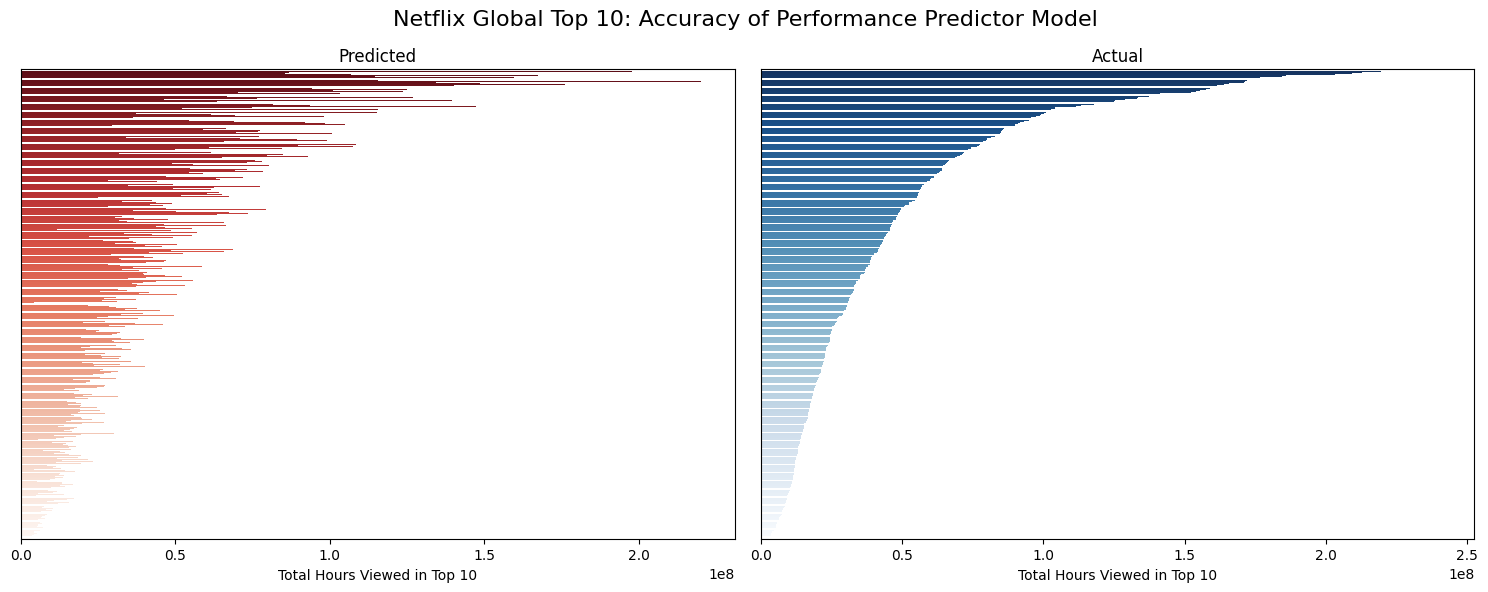

In [56]:
# Create figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot actual total hours viewed
sns.barplot(
    x="pred_total_hours_viewed_in_top_10", 
    y="season_title", 
    data=model_results_sorted,
    palette="Reds_r",
    ax=axes[0]
)
axes[0].set_xlabel("Total Hours Viewed in Top 10")
axes[0].set_ylabel("")
axes[0].set_title("Predicted")
axes[0].set_yticks([])

# Plot predicted total hours viewed
sns.barplot(
    x="total_hours_viewed_in_top_10", 
    y="season_title", 
    data=model_results_sorted,
    palette="Blues_r",
    ax=axes[1]
)
axes[1].set_xlabel("Total Hours Viewed in Top 10")
axes[1].set_ylabel("")
axes[1].set_title("Actual")
axes[1].set_yticks([])

# Add overall title
fig.suptitle("Netflix Global Top 10: Accuracy of Performance Predictor Model", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('netflix_global_top_10_model_results.png', format='png')

# Show the plots
plt.show()

### 4.3 Interpret model coefficients
The coefficients for the independent variables in our multiple linear regression model are as follows:

In [57]:
# Get the feature names from the model and the model coefficients
coefficients = model.params

pd.DataFrame({
    "Feature Name": coefficients.index,
    "Model Coefficient": coefficients
}).reset_index(drop=True)

,Feature Name,Model Coefficient
0,Intercept,3.550005
1,C(category)[T.Films (Non-English)],-0.158302
2,C(category)[T.TV (English)],0.157511
3,C(category)[T.TV (Non-English)],0.179527
4,log_week1_hours_viewed,0.854783
5,week1_rank,0.051023
6,week2_rank,-0.113856


Our model suggests that the total hours viewed in the Global Top 10, holding other variables constant, is proportional to the hours viewed in the title's first week raised to the power ${\beta_4}$ = 0.854:

<center>
(total hours viewed in top 10) $ \propto $ (hours viewed in first week in top 10)$^{\beta_4}$
</center>
<br>
Similarly, there is an exponential relationship with the title's Top 10 ranking in week 1, where the effect is scaled by the coefficient ${\beta_5}$ = 0.051:

<center><br>
(total hours viewed in top 10) $ \propto $ $e^{\beta_5(week 1 rank)}$
</center><br>

Conversely, there is an inverse exponential relationship with week 2 ranking, scaled by the coefficient ${\beta_6}$ = -0.113.

<center>
(total hours viewed in top 10) $ \propto $ $e^{\beta_6(week 2 rank)}$
</center><br>

This negative coefficient aligns with expectations: a higher rank (eg. #1) increases total hours viewed, while a lower rank (eg. #10) reduces it.

Finally, holding other variables constant, the total hours viewed in the Global Top 10 is multiplied by the following factors based on category:

|                        | Category            |
|------------------------|---------------------|
|$e^{\beta_1} =e^{-0.158} = 0.854$    | Films (Non-English) |
|$e^0 = 1$               | Films (English)     |
|$e^{\beta_2} = e^{0.157} = 1.170$     | TV (English)        |
|$e^{\beta_3} = e^{0.179} = 1.196$     | TV (Non-English)    |


### 4.4 Conclusion

We developed a multiple linear regression model to forecast the performance of Netflix Global Top 10 titles based on early data in the rankings.

The estimated model coefficients indicate that the overall performance of a Global Top 10 title is strongly influenced by its viewership in the first week. Additionally, the model suggests that TV shows generally perform better than films, with Non-English films showing the weakest performance.

Despite a strong $R^2$ and F-statistic, the model suffers from a large Mean Squared Error, and its predictive power is disappointing.

To satisfy the assumption of non-multicollinearity, we were forced to exclude week 2 viewership data. To improve predictive accuracy, it is recommended that a more complex model be developed - one that can fully incorporate correlated variables from the first two weeks of data, beyond the capabilities of multiple linear regression.